In [3]:
import pickle
import tensorflow as tf
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras import callbacks, layers, Sequential
import matplotlib.pyplot as plt
import sys
sys.path.append('../')
from dataflow import Flow

In [8]:
data1 = Flow(None, None, None, 'csv/preselected_pKmue_moreFeatures_unequalRatio.csv')
data2 = Flow(None, None, None, 'csv/preselected_pKmue_fullFeatures_equalRatio.csv')
data3 = Flow(None, None, None, 'csv/preselected_pKmue_fullFeatures_equalRatio_restrictedSideband.csv')
data4 = Flow(None, None, None, 'csv/preselected_pKmue_fullPlusFeatures_equalRatio_restrictedSideband.csv')

data = [data1, data2, data3]

In [9]:
custom_callbacks = [
    callbacks.EarlyStopping(patience=20, min_delta=0.0005, restore_best_weights=True), 
    callbacks.ReduceLROnPlateau(patience=5, factor=0.2, min_lr=0.001)
    ]

def compile_model(input_shape):
    model = Sequential([
        layers.Dense(32, activation='relu', input_shape=input_shape, kernel_regularizer=l1_l2(0.001, 0.001)),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        layers.Dense(64, activation='relu', kernel_regularizer=l1_l2(0.001, 0.001)),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        layers.Dense(128, activation='relu', kernel_regularizer=l1_l2(0.001, 0.001)),
        layers.BatchNormalization(),
        layers.Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['binary_accuracy', 'AUC', 'TruePositives', 'TrueNegatives', 'FalsePositives', 'FalseNegatives'])
    
    return model

In [10]:
def plot_history_curves(history, epochs, model_version='No version', savefig=''):
    if type(history) != dict:
        history = history.history
    
    loss = history['loss']
    val_loss = history['val_loss']
    accuracy = history['binary_accuracy']
    val_accuracy = history['val_binary_accuracy']
    auc = history['auc']
    val_auc = history['val_auc']
    epoch_range = range(1, epochs+1, 1)    

    fig, ax = plt.subplots(1, 3, figsize=(22, 6))
    ax[0].plot(epoch_range, loss, 'r.', label='Training Loss')
    ax[0].plot(epoch_range, val_loss, 'b.', label='Validation Loss')
    ax[1].plot(epoch_range, accuracy, 'r.', label='Training Accuracy')
    ax[1].plot(epoch_range, val_accuracy, 'b.', label='Validation Accuracy')
    ax[2].plot(epoch_range, auc, 'r.', label='Training AUC')
    ax[2].plot(epoch_range, val_auc, 'b.', label='Validation AUC')
    ax[0].legend()
    ax[1].legend()
    ax[2].legend()
    plt.title(model_version)
    plt.legend(frameon=False)
    if savefig != '':
        plt.savefig(savefig)
    plt.show()

def plot_history(model_version, savefig=''):
    history = pickle.load(open(f'train_history/v{model_version}', "rb"))
    nepochs = len(history['loss'])
    plot_history_curves(history, nepochs, model_version, savefig)
    

In [11]:
def fit_model(model, train_data, val_data, model_version, callbacks=None, epochs=100, batch_size=512):
    model_history = model.fit(train_data[0], train_data[1], epochs=epochs, batch_size=batch_size, validation_data=val_data, callbacks=callbacks, verbose=1)
    with open(f'train_history/v{model_version}', 'wb') as file_pi:
        pickle.dump(model_history.history, file_pi)
    model.save(f'models/v{model_version}')

In [12]:
dat = {}

#for i, d in enumerate(data):
(X_train, y_train), (X_val, y_val), (X_test, y_test) = data4.get_train_val_test_split()
#d = [(X_train, y_train), (X_val, y_val), (X_test, y_test)]
model = compile_model((X_train.shape[1],))
#dat[f'model{i}'] = [model, d]
fit_model(model, (X_train, y_train), (X_val, y_val), f'4.1.3', callbacks=custom_callbacks)
#print(f'Trained dataset {i}')

2022-02-18 14:50:36.190210: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2022-02-18 14:50:36.280916: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 2100000000 Hz


Epoch 1/100
43/43 [==============================] - 203s 143ms/step - loss: 1.4776 - binary_accuracy: 0.8336 - auc: 0.9113 - true_positives: 9295.0000 - true_negatives: 8906.0000 - false_positives: 1997.0000 - false_negatives: 1636.0000 - val_loss: 1.4536 - val_binary_accuracy: 0.8882 - val_auc: 0.9551 - val_true_positives: 3335.0000 - val_true_negatives: 3130.0000 - val_false_positives: 498.0000 - val_false_negatives: 316.0000
Epoch 2/100
43/43 [==============================] - 3s 61ms/step - loss: 1.1789 - binary_accuracy: 0.8785 - auc: 0.9454 - true_positives: 9710.0000 - true_negatives: 9471.0000 - false_positives: 1432.0000 - false_negatives: 1221.0000 - val_loss: 1.1906 - val_binary_accuracy: 0.8970 - val_auc: 0.9628 - val_true_positives: 3399.0000 - val_true_negatives: 3130.0000 - val_false_positives: 498.0000 - val_false_negatives: 252.0000
Epoch 3/100
43/43 [==============================] - 3s 67ms/step - loss: 0.9697 - binary_accuracy: 0.8891 - auc: 0.9526 - true_positives

2022-02-18 14:58:17.552286: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: models/v4.1.3/assets


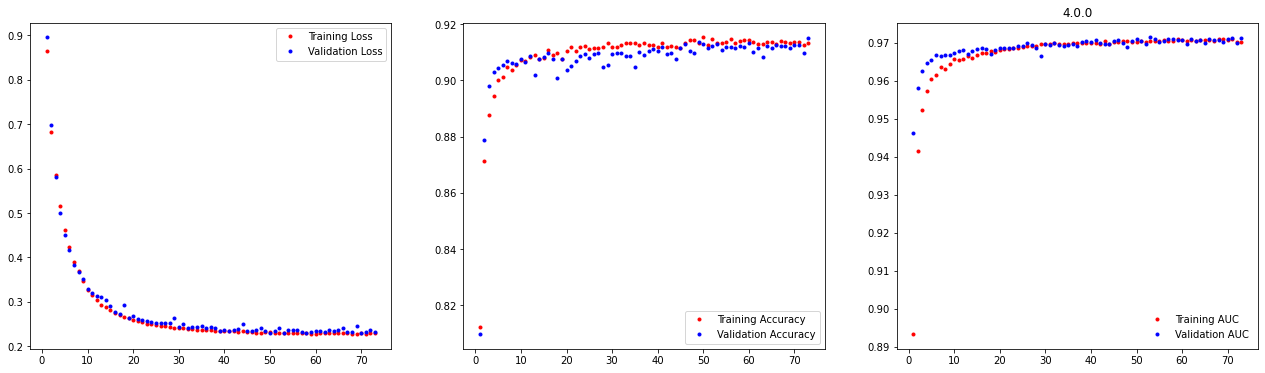

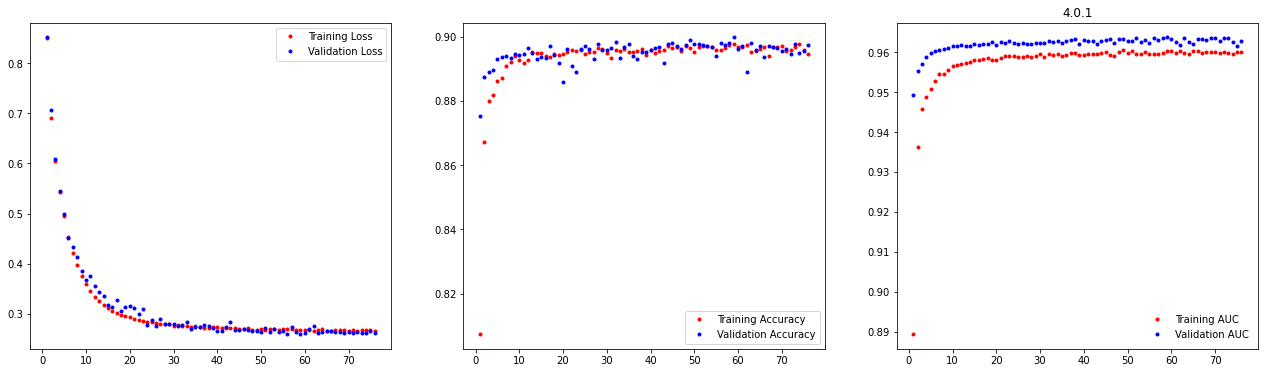

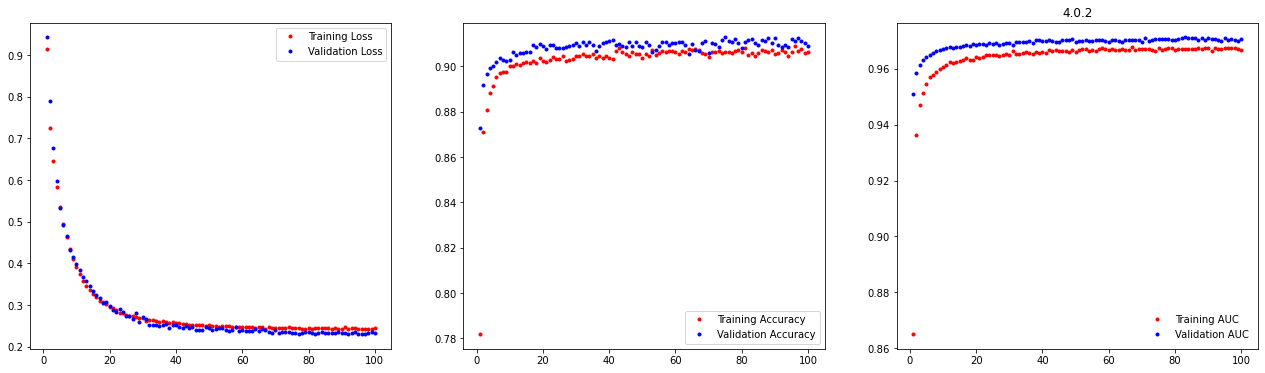

In [12]:
for i, d in enumerate(data):
    plot_history(f'4.0.{i}', f'train_history_imgs/4.1.{i}.png')

In [13]:
history1 = pickle.load(open(f'train_history/v4.1.0', "rb"))
history2 = pickle.load(open(f'train_history/v4.1.1', "rb"))
history3 = pickle.load(open(f'train_history/v4.1.2', "rb"))

## ROC Curves

In [20]:
def roc_curve(history, y_train, y_val, mversion='No Version'):
    train_signal_eff = history['true_positives']/y_train.value_counts()[1]
    val_signal_eff = history['val_true_positives']/y_val.value_counts()[1]
    # What percentage of total signal events were identified as signal events

    train_background_rej = 1 - (history['false_positives'] / y_train.value_counts()[0])
    val_background_rej = 1 - (history['val_false_positives'] / y_val.value_counts()[0])
    # The number of true positives to total positives
    
    fig, ax = plt.subplots(1, 1, figsize=(7, 5))
    ax.scatter(train_signal_eff, train_background_rej,  label='Training', s=2)
    ax.scatter(val_signal_eff, val_background_rej, label='Validation', s=2)
    ax.set_ylabel('Background Rejection (1 - False Positive Rate)')
    ax.set_xlabel('Signal Efficiency (True Positive Rate)')
    plt.title(f'Model {mversion}')
    plt.legend()
    plt.show()

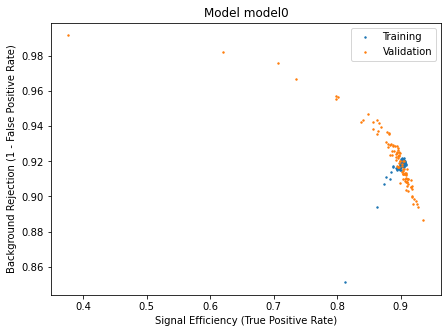

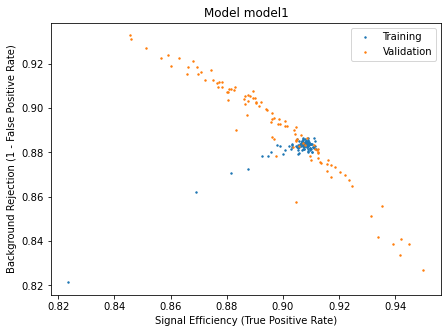

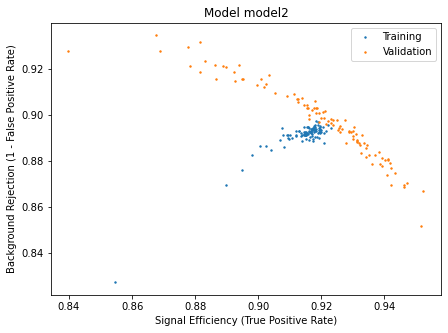

In [21]:
hists = [history1, history2, history3]

j = 0
for i, value in dat.items():
    roc_curve(hists[j], value[1][0][1], value[1][1][1], mversion=i)
    j += 1